In [6]:
# import geomloss
import numpy as np
import sys
# import torch
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

sys.path.append("..") 

from data import get_database_path, get_h5_files, read_h5_file
from emd import emd_pot, process_event_np
from visualize import plot_event_cloud, plot_optimal_transport

np.random.seed(114514)

In [7]:
database_path = get_database_path()
bkg_files, sig_files = get_h5_files()

bkg = read_h5_file(database_path, bkg_files[0]['file'])
# SM processes


In [36]:
import torch
import geomloss

a, b = torch.randn((100)), torch.randn((100))
x, y = torch.randn((100, 2)), torch.randn((100, 2))
p = 1
entreg = .1 # entropy regularization factor for Sinkhorn

# 若以欧式距离为metric，则cost function可以直接用geomloss提供的
# Sinkhorn快速解
OTLoss = geomloss.SamplesLoss(
    loss='sinkhorn', p=p,
    # 对于p=1或p=2的情形
    cost=geomloss.utils.distances if p==1 else geomloss.utils.squared_distances,
    blur=0.0001, backend='tensorized')
pW = OTLoss(a, x, b, y)
print(pW.item())

62.294647216796875


In [37]:
def process_events_torch(events):
    pts = events[:, 0]
    coords = events[:, 1:3]
    return torch.as_tensor(pts), torch.as_tensor(coords)

In [46]:
random_index = np.random.randint(len(bkg))
random_source_event = bkg[random_index]
random_target_event = bkg[random_index+1]

source_pts, source_coords = process_events_torch(random_source_event)
target_pts, target_coords = process_events_torch(random_target_event)
geomloss_emd = OTLoss(source_pts, source_coords, target_pts, target_coords)

emd = emd_pot(random_source_event, random_target_event)
print(geomloss_emd.item() - emd)


630.9178058517127


From: [ 0.   -1.75] to [ 0.   -2.05] with flow 27.41
From: [ 0.   -1.75] to [0. 0.] with flow 6.10
From: [0.47 1.  ] to [ 1.63 -0.1 ] with flow 24.21
From: [0.47 1.  ] to [0. 0.] with flow 0.14


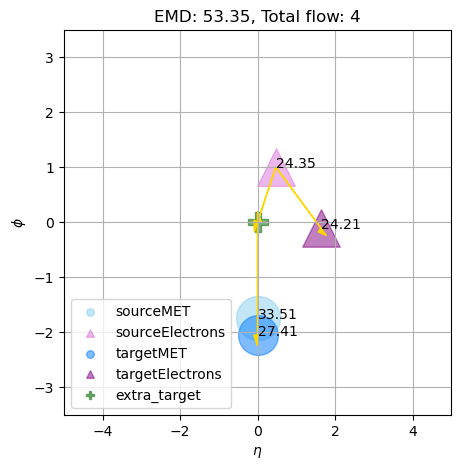

In [8]:
test_target_event = bkg[0]
test_source_event = bkg[1]
emd, flow_matrix = emd_pot(test_source_event, test_target_event, return_flow=True)
plot_optimal_transport(test_source_event, test_target_event, flow_matrix, emd, verbose=True)

From: [0.   2.41] to [1.51 1.38] with flow 21.78
From: [0.   2.41] to [0. 0.] with flow 6.78
From: [1.44 2.01] to [1.51 1.38] with flow 26.18
From: [ 3.52 -1.88] to [ 1.38 -1.47] with flow 19.48
From: [ 3.52 -1.88] to [0. 0.] with flow 1.55
From: [ 3.25 -2.81] to [0. 0.] with flow 18.67
From: [0.24 0.23] to [ 0.  -2.1] with flow 3.64
From: [0.24 0.23] to [ 1.38 -1.47] with flow 14.84
From: [-0.51 -1.02] to [ 0.  -2.1] with flow 17.36


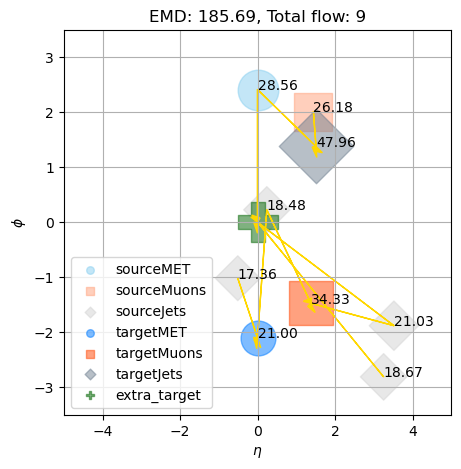

In [4]:
test_target_event = bkg[np.random.randint(0, len(bkg))]
test_source_event = bkg[np.random.randint(0, len(bkg))]
emd, flow_matrix = emd_pot(test_source_event, test_target_event, return_flow=True)
plot_optimal_transport(test_source_event, test_target_event, flow_matrix, emd, verbose=True)